In [61]:
# util
import importlib

#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

import sys
import os
sys.path.append(os.path.abspath('../quantum'))
import oracles as ora

In [18]:
def oracle(n, winner='111'):
    
    qc = QuantumCircuit(n, name='oracle')
    
    # initialize identity matrix on n qubits
    oracle_matrix = np.identity(2**n)
    # add phase shift to winner index
    win_idx = int(winner, 2)
    oracle_matrix[win_idx, win_idx] = -1
    
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_matrix), range(n))
    # convert circuit to blackbox gate
    oracle_gate = qc.to_gate()
    oracle_gate.name='oracle'
    
    return oracle_gate

In [19]:
def diffuser(n):
    
    qc = QuantumCircuit(n)
    
    # Apply a H-gate to all qubits (transformation |s> -> |00..0>)
    # Followed by X-gate (transformation |00..0> -> |11..1>)
    for q in range(n):
        qc.h(q)
        qc.x(q)
        
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    
    # Apply transformation |11..1> -> |00..0>
    # Apply transformation |00..0> -> |s>
    for q in range(n):
        qc.x(q)
        qc.h(q)

    # Convert diffuser to gate
    diff_gate = qc.to_gate()
    diff_gate.name = "diffuser"
    
    return diff_gate

In [20]:
def grover_circuit(n, oracle, marked_idcs=1):
    
    qc = QuantumCircuit(n,n)
    
    # Apply a H-gate to all qubits
    for q in range(n):
        qc.h(q)

    # add oracle
    qc.append(oracle, range(n))
    
    # add diffuser
    qc.append(diffuser(n), range(n))
    
     # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc
 

In [21]:
n = 4
winner = '1101'
oracle = oracle(n, winner)
grover_qc = grover_circuit(n, oracle)
grover_qc.draw()

┌───┐┌─────────┐┌───────────┐┌─┐         
q_0: ┤ H ├┤0        ├┤0          ├┤M├─────────
     ├───┤│         ││           │└╥┘┌─┐      
q_1: ┤ H ├┤1        ├┤1          ├─╫─┤M├──────
     ├───┤│  oracle ││  diffuser │ ║ └╥┘┌─┐   
q_2: ┤ H ├┤2        ├┤2          ├─╫──╫─┤M├───
     ├───┤│         ││           │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤3        ├┤3          ├─╫──╫──╫─┤M├
     └───┘└─────────┘└───────────┘ ║  ║  ║ └╥┘
c: 4/══════════════════════════════╩══╩══╩══╩═
                                   0  1  2  3

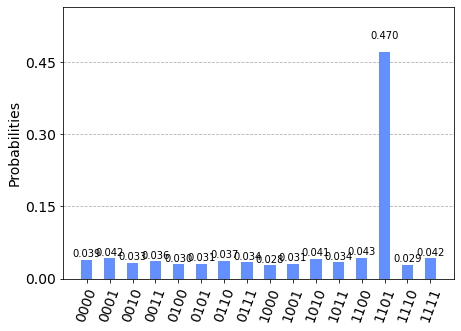

In [22]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_qc, backend=simulator, shots=1000).result().get_counts(grover_qc)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [8]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

AttributeError: 'function' object has no attribute 'cz'

In [ ]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

In [ ]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_circuit)
result = sv_sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

# apply grover to threshold oracle

In [86]:
distances = np.array([17,4,6,2,8,32,7,16])
nn = int(math.floor(math.log2(len(distances)) + 1))

In [87]:
threshold_oracles = ora.create_threshold_oracle_set(distances)

In [88]:
threshold = distances[2] #6 -> 0001 (4), 0011 (2)
oracle_qc = ora.create_oracle_lincombi(threshold, distances, threshold_oracles)

In [89]:
grover_qc = grover_circuit(nn, oracle_qc)
grover_qc.draw()

┌───┐┌───────────────┐┌───────────┐┌─┐         
q_0: ┤ H ├┤0              ├┤0          ├┤M├─────────
     ├───┤│               ││           │└╥┘┌─┐      
q_1: ┤ H ├┤1              ├┤1          ├─╫─┤M├──────
     ├───┤│  combi_oracle ││  diffuser │ ║ └╥┘┌─┐   
q_2: ┤ H ├┤2              ├┤2          ├─╫──╫─┤M├───
     ├───┤│               ││           │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤3              ├┤3          ├─╫──╫──╫─┤M├
     └───┘└───────────────┘└───────────┘ ║  ║  ║ └╥┘
c: 4/════════════════════════════════════╩══╩══╩══╩═
                                         0  1  2  3

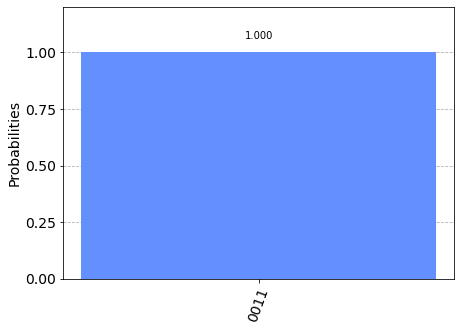

In [91]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_qc, backend=simulator, shots=1).result().get_counts(grover_qc)
plot_histogram(counts)

In [95]:
k = *counts.keys()

KeyError: 0

In [51]:
o6 = ora.create_threshold_oracle_operator(nn, [1,3])

In [52]:
qc = QuantumCircuit(nn, name='o6')
        
# convert oracle_matrix into an operator, and add it to the quantum circuit
qc.unitary(o6, range(nn))

In [53]:
grover_qc = grover_circuit(nn, qc)
grover_qc.draw()

┌───┐┌─────┐┌───────────┐┌─┐         
q_0: ┤ H ├┤0    ├┤0          ├┤M├─────────
     ├───┤│     ││           │└╥┘┌─┐      
q_1: ┤ H ├┤1    ├┤1          ├─╫─┤M├──────
     ├───┤│  o6 ││  diffuser │ ║ └╥┘┌─┐   
q_2: ┤ H ├┤2    ├┤2          ├─╫──╫─┤M├───
     ├───┤│     ││           │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤3    ├┤3          ├─╫──╫──╫─┤M├
     └───┘└─────┘└───────────┘ ║  ║  ║ └╥┘
c: 4/══════════════════════════╩══╩══╩══╩═
                               0  1  2  3

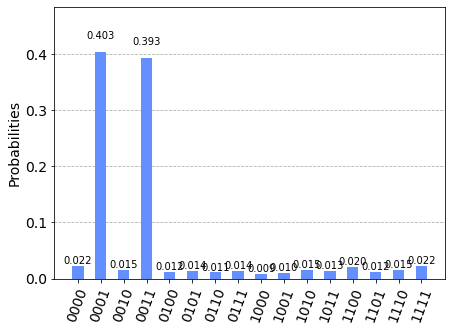

In [54]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_qc, backend=simulator, shots=1000).result().get_counts(grover_qc)
plot_histogram(counts)

In [56]:
from scipy import signal
idx, = np.where(distances==threshold) # assuming distinct values
delta_coeff = signal.unit_impulse(len(distances), idx)

In [57]:
delta_coeff

array([0., 0., 1., 0., 0., 0., 0., 0.])

In [62]:
importlib.reload(ora)
idcs_to_mark = ora.get_indices_to_mark(distances, threshold) # what for empty set (min ele)?

In [63]:
idcs_to_mark

array([1, 3])